# MSP 2. projekt

## Import knihoven

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st 
import scipy.special as sp
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.outliers_influence as smso
import statsmodels.graphics.gofplots as splt
import IPython.display as id
from scipy.stats import truncnorm
from scipy.special import softmax
from statsmodels.stats.outliers_influence import variance_inflation_factor

dataSet1 = pd.read_excel("Projekt-2_Data.xlsx", sheet_name="Úloha 1")
dataSet2 = pd.read_excel("Projekt-2_Data.xlsx", sheet_name="Úloha 2")

# 1. úloha – Bayesovské odhady

## a) Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení

Expertní odhad pro náhodnou veličinu s Poissonovým rozdělením naznačuje, že by mělo dojít k 10 připojením (celkem 10 událostí) v průběhu každých 5 ms (5 časových intervalů). Příslušné apriorní konjugované rozdělení je popsáno Gamma rozdělením s parametry $\alpha=10$ a $\beta=5$.

### 1) Apriorní a aposteriorní hustotou parametru Poissonova rozdělení 𝜆



Apriorní hustota je pro nás, jak jsme si již řekli, Gama rozdělení. Aposteriorní hustota je pak hustota Gama rozdělení s parametry viz tabulka https://en.wikipedia.org/wiki/Conjugate_prior

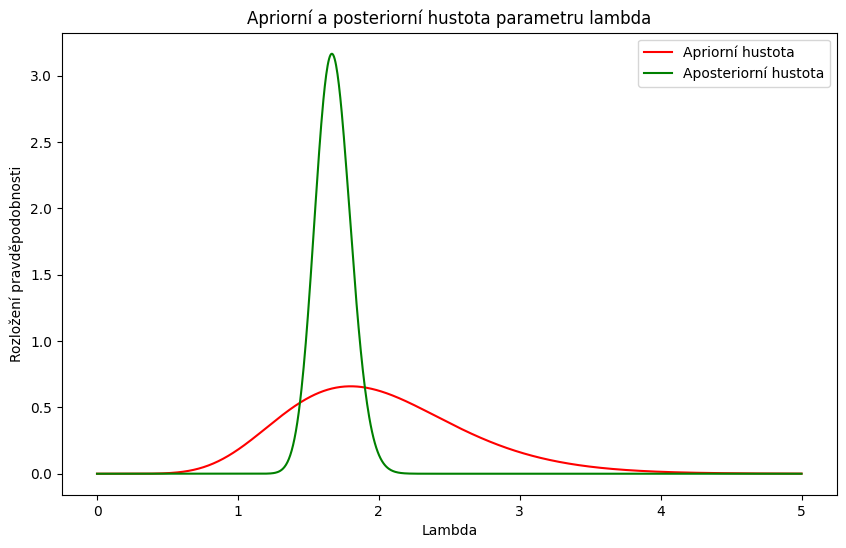

In [2]:
# apriorni parametry
alphaPrior = 10
betaPrior = 5

# vyfiltrovana data
observations = np.array(dataSet1["uloha_1 a)"].dropna().values)

# aposteriorni parametry
alphaPost = alphaPrior + observations.sum()
betaPost = betaPrior + len(observations)

# lambda - 1000 bodu mezi 0 a max
lambdas = np.linspace(0, observations.max(), 1000)

# pravdepodobnostni funkce
prior = st.gamma.pdf(lambdas, alphaPrior, scale=1/betaPrior)
posterior = st.gamma.pdf(lambdas, alphaPost, scale=1/betaPost)

# graf
plt.figure(figsize=(10, 6))
plt.plot(lambdas, prior, label='Apriorní hustota', color='red')
plt.plot(lambdas, posterior, label='Aposteriorní hustota', color='green')
plt.legend()
plt.title('Apriorní a posteriorní hustota parametru lambda')
plt.xlabel('Lambda')
plt.ylabel('Rozložení pravděpodobnosti')
plt.show()


### 2) Apriorní a aposteriorní prediktivní hustotou pozorovaní 𝑥 za jeden časový interval



Pro výpočet parametru prediktivní hustoty využijeme binomického rozdělení, jehož apriorní parametry jsou rovněž uvedeny v tabulce.

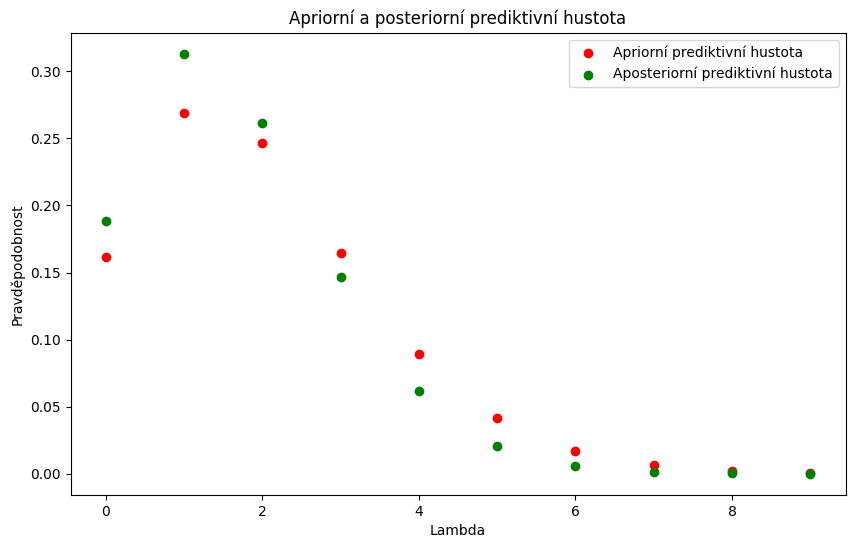

In [3]:
# apriorni parametry
binomialAlphaApriori = alphaPrior
binomialBetaPrior = betaPrior/(betaPrior + 1)

# posteriorni parametry
binomialAlphaPost = alphaPost
binomialBetaPost = betaPost/(betaPost + 1)

k = np.arange(0, 10) # experimentalne nastaveno na 10

predictive_probs_prior = st.nbinom.pmf(k, binomialAlphaApriori, binomialBetaPrior)
predictive_probs_posterior = st.nbinom.pmf(k, binomialAlphaPost, binomialBetaPost)

plt.figure(figsize=(10, 6))
plt.scatter(k, predictive_probs_prior, label='Apriorní prediktivní hustota', color='red')
plt.scatter(k, predictive_probs_posterior, label='Aposteriorní prediktivní hustota', color='green')
plt.title('Apriorní a posteriorní prediktivní hustota')
plt.xlabel('Lambda')
plt.ylabel('Pravděpodobnost')
plt.legend()
plt.show()


### 3) 95% interval spolehlivosti pro parametr 𝜆 z apriorního a aposteriorního rozdělení


Interval spolehlivosti odhadu parametru $\lambda$ pro požadovanou hladinu spolehlivosti 95 % je dán výrazem $(\hat{\lambda}g_{1-\alpha/2}, \hat{\lambda}g_{\alpha/2})$, kde:

- $\hat{\lambda}$ představuje bodový odhad parametru $\lambda$,
- $1 - \alpha$ určuje hladinu významnosti (pro 95 % spolehlivost je $\alpha = 0.05$),
- $g_{k}$ značí $k$-tý percentil Gamma rozdělení.

Obě apriorní i aposteriorní rozdělení jsou modelována pomocí Gamma rozdělení, což znamená, že bodové odhady jejich parametrů $\lambda$ jsou definovány následovně:
$$
\hat{\lambda} = \frac{\alpha + \sum^{n}_{i=1} x_i}{\beta + n}.
$$

Konečně můžeme vypočítat, že interval je ohraničen na [2.5; 97.5] percentil Gamma rozdělení.

In [4]:
# interval spolehlivosti pro parametr lambda z apriorního a aposteriorního rozdělení
lambdaPrior025 = st.gamma.ppf(0.025, a=alphaPrior, scale=1/betaPrior)
lambdaPrior975 = st.gamma.ppf(0.975, a=alphaPrior, scale=1/betaPrior)

lambdaPost025 = st.gamma.ppf(0.025, a=alphaPost, scale=1/betaPost)
lambdaPost975 = st.gamma.ppf(0.975, a=alphaPost, scale=1/betaPost)

print(f'95% interval spolehlivosti pro parametr lambda z apriorního rozdělení: <{round(lambdaPrior025, 5)}, {round(lambdaPrior975, 5)}>')
print(f'95% interval spolehlivosti pro parametr lambda z aposteriorního rozdělení: <{round(lambdaPost025, 5)}, {round(lambdaPost975, 5)}>')

95% interval spolehlivosti pro parametr lambda z apriorního rozdělení: <0.95908, 3.41696>
95% interval spolehlivosti pro parametr lambda z aposteriorního rozdělení: <1.43769, 1.93272>


Porovnáním intervalů zjistíme, že apriorní rozdělení poskytuje mnohem širší rozsah možných hodnot, zatímco aposteriorní rozdělení vykazuje výrazně užší interval se stejnou spolehlivostí. Obecně platí, že apriorní rozložení vychází z expertní informace, aniž by byla k dispozici konkrétní data. Naopak aposteriorní rozložení kombinuje expertní informaci s reálnými naměřenými daty. Výsledky tak dávají smysl: před započítáním skutečných hodnot je interval širší (s více možnými hodnotami parametru), a až po zahrnutí naměřených hodnot získáváme užší a přesnější interval.

### 4) Výběr dvou aposteriorních bodových odhadů parametru 𝜆


V rámci bodových odhadů je možné vybrat průměr, medián nebo modus. Pokud jsou data nevychýlená, očekáváme, že tyto tři hodnoty budou ekvivalentní. V obecném smyslu platí, že průměr je citlivý na extrémní hodnoty, ale zahrnuje všechna data, což je užitečné v případě, kdy důvěřujeme rozumnému modelování a nemáme konkrétní důvody některým hodnotám nevěřit.

Medián reprezentuje střední hodnotu intervalu a je odolnější vůči extrémním hodnotám než průměr. Ukazuje hodnotu, pod a nad kterou leží stejné procento dat (tedy 50. percentil). V případě výrazných odchylek od normálního rozdělení může být medián lepším ukazatelem střední hodnoty než průměr. Nicméně v našem konkrétním případě pozorujeme velmi podobné hodnoty obou bodových odhadů, což naznačuje, že data pravděpodobně nejsou vychýlena.

In [5]:
# prvni bodovy odhad parametru lambda
mean = alphaPost/betaPost

# druhy bodovy odhad parametru lambda
median = st.gamma.median(a=alphaPost, scale=1/betaPost)

print(f"Bodový odhad parametru lambda za použití střední hodnoty: {mean:.5f}")
print(f"Bodový odhad parametru lambda za použití mediánu: {median:.5f}")

Bodový odhad parametru lambda za použití střední hodnoty: 1.67619
Bodový odhad parametru lambda za použití mediánu: 1.67302


### 5) Výběr apriorního a aposteriorního bodového odhadu počtu pozorování

In [6]:
observationsPrior = alphaPrior * (1 - betaPrior / (betaPrior + 1)) / (betaPrior / (betaPrior + 1))
observationsPost = alphaPost * (1 - betaPost / (betaPost + 1)) / (betaPost / (betaPost + 1))

print(f"Apriorní očekávaný počet pozorování: {observationsPrior:.5f}")
print(f"Aposteriorní očekávaný počet pozorování: {observationsPost:.5f}")

Apriorní očekávaný počet pozorování: 2.00000
Aposteriorní očekávaný počet pozorování: 1.67619


Bodový odhad parametru lambda pomocí průměru vyšel na hodnotě 2, což odpovídá očekávanému výsledku, když předpokládáme 10 připojení za 5 ms. Nicméně, tento odhad nezohledňuje aktuální data, která vedou k odlišnému výsledku 1,67. Tato odchylka naznačuje, že skutečný průměrný počet připojení za 1 ms je pravděpodobně nižší než 2, jak bylo očekáváno.

## b) Aproximace diskrétním rozdělením

### 1) Graf apriorní, aposteriorní hustotou a funkce věrohodnosti

Namísto zadané apriorní pravděpodobnosti máme nyní naměřená data. Pro získání hustoty pravděpodobnosti $h(b)$ nyní spočteme pro každou skupinu nejvyšší hodnotu.

In [7]:
observations = dataSet1["uloha_1 b)_pozorování"].dropna().values

# nalezneme maxima pro každou skupinu
data = dataSet1[['skupina', 'uloha_1 b)_prior']]  # Selecting columns for group and task_1b_observation
groupedData = data.groupby("skupina")["uloha_1 b)_prior"]
maxValues = []

for k, v in groupedData:
    maxValues.append(max(v))

maxValues_inGroup = pd.DataFrame({"skupina": groupedData.groups.keys(), "max_value": maxValues})

Tímto jsme dokázali získat pro každou skupinu největší hodnoty. Nyní je rozřadíme do binů, díky čemuž získáme apriorní rozdělení.
Dále pracujeme s informacemi ze zadání, které říkají, že délka zpracování procesu v milisekundách má odseknuté normální rozdělení s určenými parametry, což nám říká, že rozdělení je normální pouze v určitém rozsahu. Pro výpočet věrohodnostní funkce využijme tedy odseknuté normální rozdělení. Pro každou z 50 možností parametru $b$ získáváme pravděpodobnost (normalizovanou pomocí funkce SoftMax na intervalu $\langle0, 1\rangle$) v logaritmické doméně, což nám poskytuje informaci o pravděpodobnosti správnosti hodnoty parametru $b$.

V této fázi máme apriorní hustotu a funkci věrohodnosti. Bayesovým vzorcem poté vypočítáváme aposteriorní hustotu.

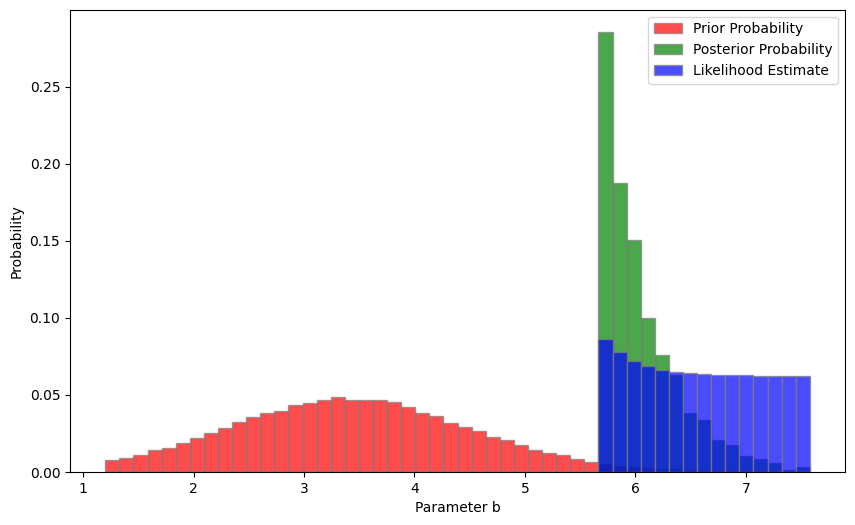

In [8]:
# Creating prior histogram
numOfValuesInBin, binsEdges = np.histogram(data["uloha_1 b)_prior"], bins=50)
priorProb = numOfValuesInBin / numOfValuesInBin.sum()
binsCenters = binsEdges[:-1] + np.diff(binsEdges) / 2

# Creating output
likelihoodEstimate = []

# Calculating likelihood for each bin center
mu = 3
sigma = 1
for binCenter in binsCenters:
    likelihoodEstimate.append(np.sum(truncnorm(a=(1 - mu) / sigma, b=(binCenter - mu) / sigma, loc=mu, scale=sigma).logpdf(observations)))

# Softmax for converting likelihood to probabilities
likelihoodProbs = softmax(likelihoodEstimate)

# Creating posterior probabilities
posteriorEstimate = priorProb * likelihoodProbs
posteriorProbs = posteriorEstimate / np.sum(posteriorEstimate)

# Plotting results
plt.figure(figsize=(10, 6))
plt.hist(binsEdges[:-1], binsEdges, weights=priorProb, label='Prior Probability', alpha=0.7, color='red', edgecolor='grey')
plt.hist(binsEdges[:-1], binsEdges, weights=posteriorProbs, label='Posterior Probability', alpha=0.7, color='green', edgecolor='grey')
plt.hist(binsEdges[:-1], binsEdges, weights=likelihoodProbs, label='Likelihood Estimate', alpha=0.7, color='blue', edgecolor='grey')
plt.xlabel('Parameter b')
plt.ylabel('Probability')
plt.legend()
plt.show()


### 2) 95% interval spolehlivosti parametru $b$


Nejprve seřaďme hodnoty parametru vzestupně podle pravděpodobnosti. Dále spočteme komulativní aposteriorní pravděpodobnosti. Tím dostaneme aposteriorní distribuční funkci. Z té jsme pak schopni najít hodnoty pro interval 95% spolehlivosti.

In [9]:
# Kombinujte středy binů s odpovídajícími aposteriorními pravděpodobnostmi pomocí funkce zip
# Seřaďte objekty sestupně podle druhé hodnoty (pravděpodobnosti) od největší po nejmenší
sortedPost = sorted(zip(binsCenters, posteriorProbs), key=lambda x: x[1], reverse=True)

# Spočítejte kumulativní (seřazené) aposteriorní pravděpodobnosti (kumulativní součet pole),
# což nám dává kumulativní distribuční funkci aposteriorní pravděpodobnosti
cumulativeProbs = np.cumsum([prob for _, prob in sortedPost])

# Pomocí kumulativní distribuční funkce najděte rozsah 95% intervalu spolehlivosti
# (argmax vrací index prvního prvku, který je větší nebo roven hledané hodnotě)
lowerBoundIndex = np.argmax(cumulativeProbs >= 0.025)
upperBoundIndex = np.argmax(cumulativeProbs >= 0.975)

# Indexy slouží k přístupu k hodnotám parametru b
lowerBound = sortedPost[lowerBoundIndex][0]
upperBound = sortedPost[upperBoundIndex][0]

print(f"95% confidence interval for parameter b from the posterior density: <{lowerBound:.5f}, {upperBound:.5f}>")


95% confidence interval for parameter b from the posterior density: <5.72921, 7.00481>


### 3) Bodové odhady parametru $b$

Jako bodové odhady zvolíme průměr a modus. Pro výpočet průměru opět využijeme diskrétních hodnot. Modus spočítáme jako $argmax$ z aposteriorní pravděpodobnostní funkce (diskretizované hustoty).

In [10]:
# Bodové odhady parametru b
mean = np.sum(binsCenters * posteriorProbs)      # Váhovaný průměr (každý parametr b má přiřazenou pravděpodobnost)
mode = binsCenters[np.argmax(posteriorProbs)]    # Parametr b s největší pravděpodobností

print(f"Bodový odhad parametru b za použití průměru: {mean:.5f}")
print(f"Bodový odhad parametru b za použití modu: {mode:.5f}")


Bodový odhad parametru b za použití průměru: 6.04911
Bodový odhad parametru b za použití modu: 5.72921


# 2. úloha – Regrese

Nejprve se podívejme, jak vypadají data pro druhý dataset.

In [11]:
print(dataSet2)

      OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]
0        iOS         4113          0.8283        0.1717         47
1        iOS         7549          0.3461        0.6539         46
2    Windows         8855          0.2178        0.7822         55
3    Android         8870          0.0794        0.9206         56
4      MacOS         9559          0.7282        0.2718         76
..       ...          ...             ...           ...        ...
497      iOS         5315          0.1974        0.8026         28
498    MacOS         1392          0.2373        0.7627         24
499      iOS         6014          0.8112        0.1888         54
500  Android         5118          0.2345        0.7655         39
501    MacOS         2660          0.9390        0.0610         55

[502 rows x 5 columns]


Nejprve budeme chtít dataset vyčistit od případných korelovaných dat. Pak bude třeba nalézt vychýlená data, která mohou nějak ovlivňovat model. Až poté budeme moci začít model vytvářet.

### Čištění a úprava vstupních dat, příprava

In [12]:
# Kontrola, zda `1 - InteractingPct = ScrollingPct`
check = 1 - dataSet2['InteractingPct'] - dataSet2['ScrollingPct']

# Výpis datového rámce s přidaným sloupcem 'Check'
print(check)

0      9.714451e-16
1      8.881784e-16
2      0.000000e+00
3      0.000000e+00
4      5.551115e-17
           ...     
497    0.000000e+00
498    8.881784e-16
499    9.714451e-16
500    1.110223e-16
501    5.551115e-17
Length: 502, dtype: float64


Jak z výpisu můžeme vidět, atributy `InteractingPct` a `ScrollingPct` jsou na sobě závislé (hodnoty jsou po provedení výpočtu velice nízké - a tedy jsou na sobě závislé), proto můžeme jeden atribut bez starostí odstranit. Než tak učiníme, ještě se na ně podíváme v grafu korelační matice, která nám může ukázat jednotlivé závislosti vizuálně.

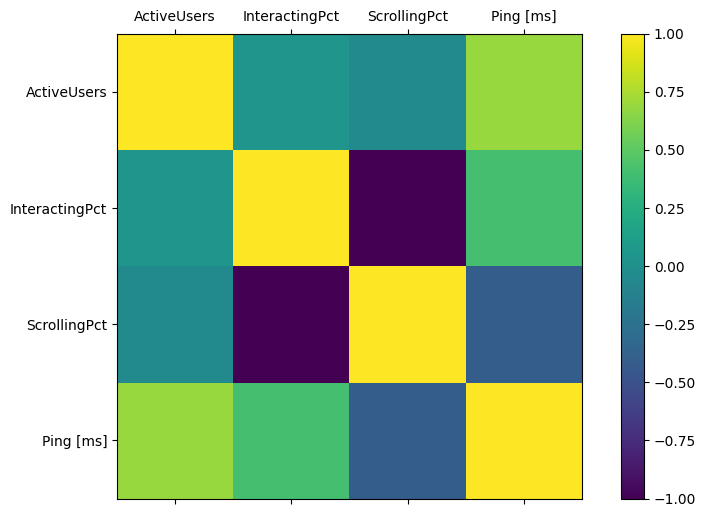

In [13]:
atributes = dataSet2.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 6))
plt.matshow(atributes.corr(), fignum=1)
plt.xticks(range(len(atributes.columns)), atributes.columns)
plt.yticks(range(len(atributes.columns)), atributes.columns)
plt.colorbar()
plt.show()

## 1) Určení vhodného regresního modelu

### Plný kvadratický model 

Má následující tvar:

$
y= \beta_1 + \beta_2 \cdot OSType + \beta_3 \cdot ActiveUsers + \beta_4 \cdot InteractingPct + \beta_5 \cdot ScrollingPct + \beta_6 \cdot OSType \cdot ActiveUsers + \beta_7 \cdot OSType \cdot InteractingPct + \beta_8 \cdot OSType \cdot ScrollingPct + \beta_9 \cdot ActiveUsers \cdot InteractingPct + \beta_{10} \cdot ActiveUsers \cdot ScrollingPct + \beta_{11} \cdot InteractingPct \cdot ScrollingPct + \beta_{12} \cdot OSType^2 + \beta_{13} \cdot ActiveUsers^2 + \beta_{14} \cdot InteractingPct^2 + \beta_{15} \cdot ScrollingPct^2
$

V tomto modelu máme jednu kategoriální proměnnou, kterou budeme muset zakódovat, díky čemuž bude mít číselnou reprezentaci. Jedná se o $OSType$. Pro to využijeme *one-hot encoding*. V této proměnné se vyskytují čtyři hodnoty, ze kterých se stanou sloupce a vždy tak bude na řádku v tabulce právě jedna 1 u daného operačního systému. Tím nám tedy zanikne jeden sloupec - OSType, ale přibudou další čtyři.

Jak jsme si řekli výše, dva sloupečky jsou na sobě závislé a proto můžeme jeden ostranit. V konečném důstledku se nám tabulka rozšíří o 2 sloupce.

In [14]:
# odstraneni ScrollingPct sloupce + prejmenovani Ping sloupce pro jednodussi zachazeni
dataSet2Changed = dataSet2.drop('InteractingPct', axis=1)
dataSet2Changed = dataSet2Changed.rename(columns={'Ping [ms]': 'Ping'})

# one hot encoding
dataSet2_OneHot = pd.get_dummies(dataSet2Changed["OSType"]).join(dataSet2Changed.drop("OSType", axis=1))

dataSet2_OneHot

,Android,MacOS,Windows,iOS,ActiveUsers,ScrollingPct,Ping
0,False,False,False,True,4113,0.1717,47
1,False,False,False,True,7549,0.6539,46
2,False,False,True,False,8855,0.7822,55
3,True,False,False,False,8870,0.9206,56
4,False,True,False,False,9559,0.2718,76
...,...,...,...,...,...,...,...
497,False,False,False,True,5315,0.8026,28
498,False,True,False,False,1392,0.7627,24
499,False,False,False,True,6014,0.1888,54
500,True,False,False,False,5118,0.7655,39


### Ořezávání atrubutů

Model ořežeme o atributy, druhé mocniny a kombinace jak jsme si řekli výše a podíváme se na výstup.

In [15]:
fullModel = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + Android:ScrollingPct + \
                        MacOS:ActiveUsers + MacOS:ScrollingPct + \
                        Windows:ActiveUsers + Windows:ScrollingPct + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers) + I(ScrollingPct*ScrollingPct)", data=dataSet2_OneHot)
results = fullModel.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        21:47:48   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Lineárně závislé atributy jsme odstranili už ze začátku, avšak jsme se nevyhnuli multikolinearitě, což nám napovídá i OLS model. Jedná se samozřejmě o jednotlivé sloupce vytvořené z OSType atributu. Dále pak jakýkoli jednoduchý atribut na druhou, protože to je na sobě jednoznačně závislé.

Kdyby byl model co nejmenší, determinant matice plánu by měl být nulový a jednotlivé koeficienty by z ostatních nemělo být možno odhadnout. 

Pro zjištění multikolinearity spočítáme VIF. Díky výsledku z tohoto faktoru můžeme odhadnout, jak moc jsou prediktory závislé. Pokud je hodnota faktoru do 10, prediktory jsou nezávislé. Pokud je to nad 10, pak už závislé jsou a musíme s tím něco dělat, protože to nám může ovlivňovat výsledky.

In [16]:
# Extrahování exogenních proměnných z plného modelu
exogVariables = pd.DataFrame(fullModel.exog, columns=fullModel.exog_names)

# Výpočet Variance Inflation Factor (VIF) pro každou exogenní proměnnou
vifValues = pd.Series([variance_inflation_factor(exogVariables.values, i) 
                       for i in range(exogVariables.shape[1])], 
                      index=exogVariables.columns)

# Vytvoření DataFrame pro hodnoty VIF
vifDataFrame = vifValues.to_frame()
vifDataFrame.columns = ['VIF']

# Zobrazení DataFrame s hodnotami VIF
print(vifDataFrame)

                                      VIF
Intercept                       70.251414
Android[T.True]                 14.305992
MacOS[T.True]                   12.960231
Windows[T.True]                 14.473358
ActiveUsers                     29.055991
Android[T.True]:ActiveUsers     10.021529
MacOS[T.True]:ActiveUsers        9.485078
Windows[T.True]:ActiveUsers      9.286836
ScrollingPct                    24.195197
Android[T.True]:ScrollingPct     6.730996
MacOS[T.True]:ScrollingPct       6.039982
Windows[T.True]:ScrollingPct     7.188844
ActiveUsers:ScrollingPct         8.705628
I(ActiveUsers * ActiveUsers)    22.499134
I(ScrollingPct * ScrollingPct)  16.422293


Po vzoru demonstračního cvičení odstraníme multikolinearitu standardizací do rozsahu $\langle-1, 1 \rangle$.

In [17]:
dataSet2_OneHot = dataSet2_OneHot.astype(float)
mins = dataSet2_OneHot.min(axis=0)
maxes = dataSet2_OneHot.max(axis=0)
scaledAndCenteredData  = (dataSet2_OneHot - mins) / (maxes - mins) * 2 - 1

scaledAndCenteredData 

,Android,MacOS,Windows,iOS,ActiveUsers,ScrollingPct,Ping
0,-1.0,-1.0,-1.0,1.0,-0.191837,-0.658752,-0.088608
1,-1.0,-1.0,-1.0,1.0,0.509388,0.307484,-0.113924
2,-1.0,-1.0,1.0,-1.0,0.775918,0.564573,0.113924
3,1.0,-1.0,-1.0,-1.0,0.778980,0.841900,0.139241
4,-1.0,1.0,-1.0,-1.0,0.919592,-0.458171,0.645570
...,...,...,...,...,...,...,...
497,-1.0,-1.0,-1.0,1.0,0.053469,0.605450,-0.569620
498,-1.0,1.0,-1.0,-1.0,-0.747143,0.525498,-0.670886
499,-1.0,-1.0,-1.0,1.0,0.196122,-0.624487,0.088608
500,1.0,-1.0,-1.0,-1.0,0.013265,0.531109,-0.291139


Nyní se podívejme na OLS model znovu.

In [18]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + Android:ScrollingPct + \
                        MacOS:ActiveUsers + MacOS:ScrollingPct + \
                        Windows:ActiveUsers + Windows:ScrollingPct + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers) + I(ScrollingPct*ScrollingPct)", data=scaledAndCenteredData )
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        21:47:48   Log-Likelihood:                 247.09
No. Observations:                 502   AIC:                            -464.2
Df Residuals:                     487   BIC:                            -400.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Hláška o velké multikolinearitě zmizela, takže standardizace opravdu pomohla.

V následujících krocích budeme postupně odstraňovat problematické prediktory (tedy ty s nejvyšší hodnotou ve sloupci `P>|t|`). Musíme však sledovat hodnotu `R-squared`, která musí být nejhůře stejně tak dobrá jako v předchozím kroku.

In [19]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + Android:ScrollingPct + \
                        MacOS:ActiveUsers + MacOS:ScrollingPct + \
                        Windows:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers) + I(ScrollingPct*ScrollingPct)", data=scaledAndCenteredData )
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     202.8
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          3.57e-187
Time:                        21:47:48   Log-Likelihood:                 247.09
No. Observations:                 502   AIC:                            -466.2
Df Residuals:                     488   BIC:                            -407.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [20]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + MacOS:ScrollingPct + \
                        Windows:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers) + I(ScrollingPct*ScrollingPct)", data=scaledAndCenteredData )
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     220.1
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          2.38e-188
Time:                        21:47:48   Log-Likelihood:                 247.07
No. Observations:                 502   AIC:                            -468.1
Df Residuals:                     489   BIC:                            -413.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [21]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + \
                        Windows:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers) + I(ScrollingPct*ScrollingPct)", data=scaledAndCenteredData )
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     240.6
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.57e-189
Time:                        21:47:48   Log-Likelihood:                 247.03
No. Observations:                 502   AIC:                            -470.1
Df Residuals:                     490   BIC:                            -419.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [22]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers) + I(ScrollingPct*ScrollingPct)", data=scaledAndCenteredData )
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.5
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.62e-190
Time:                        21:47:48   Log-Likelihood:                 246.47
No. Observations:                 502   AIC:                            -470.9
Df Residuals:                     491   BIC:                            -424.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [23]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers)", data=scaledAndCenteredData )
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     293.7
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.62e-191
Time:                        21:47:48   Log-Likelihood:                 245.89
No. Observations:                 502   AIC:                            -471.8
Df Residuals:                     492   BIC:                            -429.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Nyní již u žádného koeficientu nevidíme čísla výrazně vyšší než 0,0. Model jsme tímto zjednodušili, ale podíváme-li se na koeficient determinizace, nezměnili jsme schopnost model predikovat.

Statistika `Durbin-Watson` naznačuje, že za sebou jdoucí rezidua mají minimální pozitivní vzájemnou korelaci, což znamená, že nejsou významně autokorelovaná a navzájem se příliš neovlivňují. Ideální hodnota této statistiky je 2, a my se k ní přibližujeme.

Na druhé straně, statistiky `Omnibus` a `Jarque-Bera` vykazují vysoké hodnoty, což nám ukazuje, že rezidua nemají normální rozdělení. Toto může být způsobeno existencí několika vlivných bodů, se kterými jsme se dosud nezabývali. Pokud identifikujeme nějaký vlivný bod a považujeme ho za problematický, můžeme ho odstranit, což by mohlo zlepšit kvalitu našeho regresního modelu.

### Určení vhodnosti dat pro regresní model

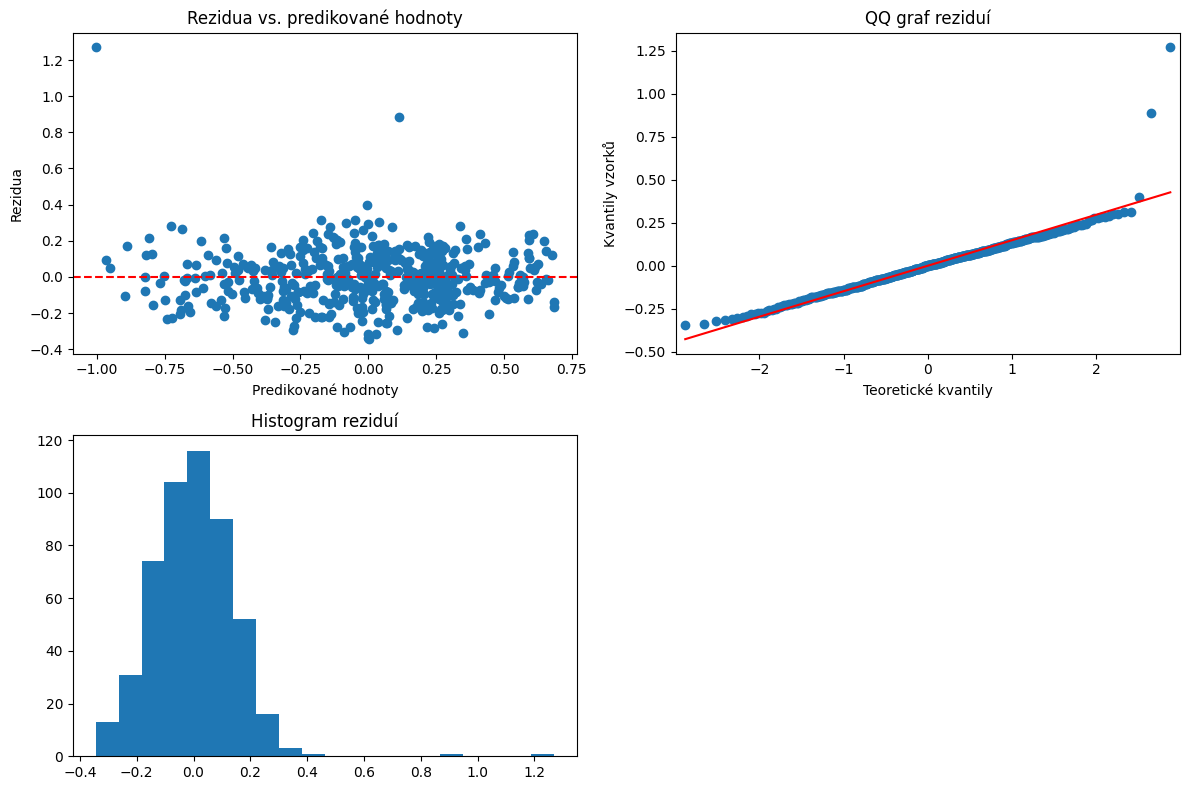

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Rezidua vs. predikovane hodnoty
axs[0, 0].scatter(results.fittedvalues, results.resid)
axs[0, 0].axhline(y=0, color="red", linestyle="--")
axs[0, 0].set_title('Rezidua vs. predikované hodnoty')
axs[0, 0].set_xlabel('Predikované hodnoty')
axs[0, 0].set_ylabel('Rezidua')

# QQ graf rezidui
splt.qqplot(results.resid, line='s', ax=axs[0, 1])
axs[0, 1].set_title('QQ graf reziduí')
axs[0, 1].set_xlabel('Teoretické kvantily')
axs[0, 1].set_ylabel('Kvantily vzorků')

# histogram rezidui
axs[1, 0].hist(results.resid, bins=20)
axs[1, 0].set_title('Histogram reziduí')

# odstraneni prazdneho subplotu
fig.delaxes(axs[1, 1])

plt.tight_layout()
plt.show()

Z grafů můžeme vypozorovat dva vlivné body, které narušují jak normální rozdělení, tak celkovou kvalitu modelu. Pokud se jedná o chybná data, pak je odstraníme a aktualizujeme náš ořezaný/zjednodušený model.

In [25]:
# Identifikace odlehlych hodnot
outliers_indices = results.resid[results.resid > 0.5].index

for index in outliers_indices:
    print(index)
    print(str(dataSet2.iloc[index]) + "\n")

255
OSType            Windows
ActiveUsers          5513
InteractingPct     0.4912
ScrollingPct       0.5088
Ping [ms]              90
Name: 255, dtype: object

476
OSType             MacOS
ActiveUsers          153
InteractingPct    0.2111
ScrollingPct      0.7889
Ping [ms]             61
Name: 476, dtype: object



Tyto hodnoty můžeme odstranit, protože s nimi nechceme modelovat.

In [26]:
# odstraneni odlehlych hodnot (normalizovanych dat)
scaledAndCenteredData  = scaledAndCenteredData.drop(outliers_indices)
scaledAndCenteredData  = scaledAndCenteredData.reset_index(drop=True)

# odstraneni odlehlych hodnot (puvodni data)
dataSet2 = dataSet2.drop(outliers_indices)
dataSet2 = dataSet2.reset_index(drop=True)

Nyní se znovu podívejme na model, jestli zůstal stále se stejnými, či lepšími hodnotami.

In [27]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers)", data=scaledAndCenteredData )
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     388.1
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.43e-216
Time:                        21:47:49   Log-Likelihood:                 308.63
No. Observations:                 500   AIC:                            -597.3
Df Residuals:                     490   BIC:                            -555.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

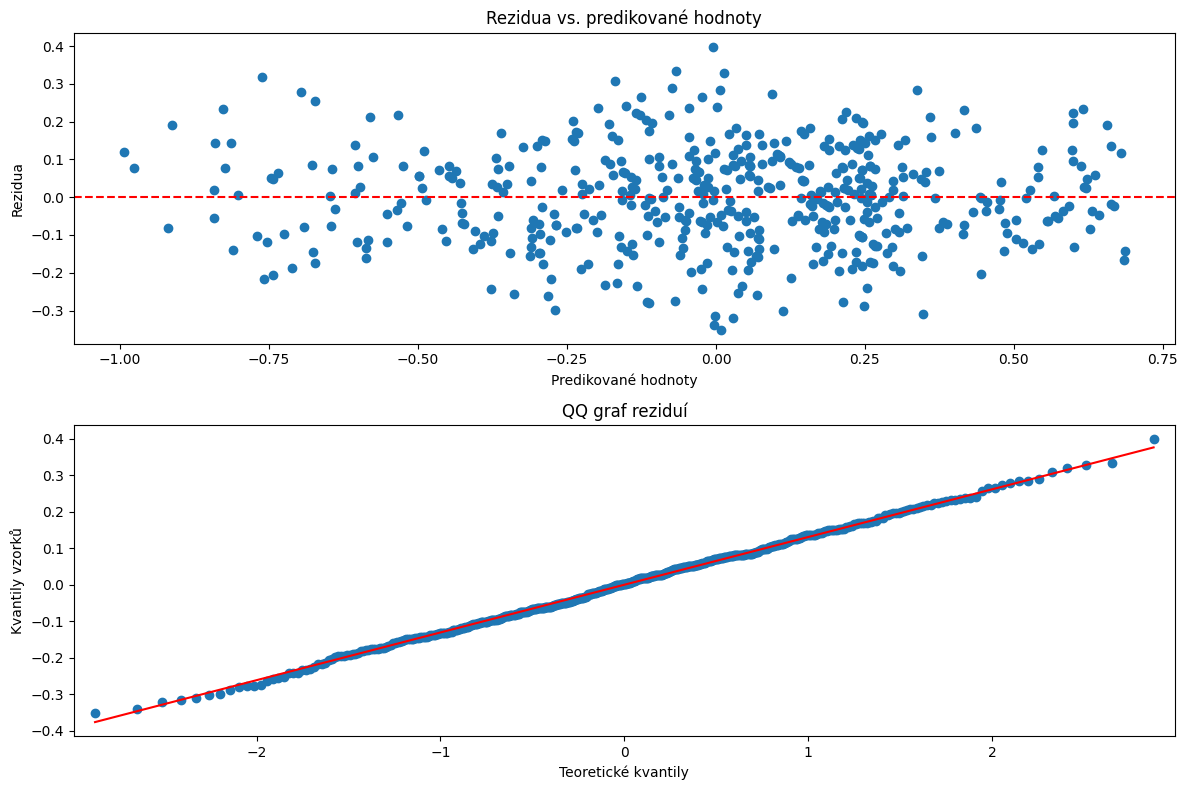

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Rezidua vs. predikovane hodnoty
axs[0].scatter(results.fittedvalues, results.resid)
axs[0].axhline(y=0, color="red", linestyle="--")
axs[0].set_title('Rezidua vs. predikované hodnoty')
axs[0].set_xlabel('Predikované hodnoty')
axs[0].set_ylabel('Rezidua')

# QQ graf rezidui
splt.qqplot(results.resid, line='s', ax=axs[1])
axs[1].set_title('QQ graf reziduí')
axs[1].set_xlabel('Teoretické kvantily')
axs[1].set_ylabel('Kvantily vzorků')

plt.tight_layout()
plt.show()

Model bude ještě třeba znormalizovat, ale jinak vidíme, že model neobsahuje žádné nevýznamné prediktory či odlehlé hodnoty a tedy - náš model je finální. Po normalizaci už můžeme napsat jeho finální podobu.

In [29]:
# opetovna normalizace (aktualizovanych) dat
minValues = scaledAndCenteredData.min(axis=0)
maxValues = scaledAndCenteredData.max(axis=0)
scaledAndCenteredData  = -1+2*((scaledAndCenteredData -minValues)/(maxValues - minValues))
scaledAndCenteredData.head()

model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers)", data=scaledAndCenteredData )
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     388.1
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.43e-216
Time:                        21:47:50   Log-Likelihood:                 269.14
No. Observations:                 500   AIC:                            -518.3
Df Residuals:                     490   BIC:                            -476.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       


Výsledná **rovnice modelu** pro **normalizované vstupy** tedy je:

$
Ping = 0.36 + 0.0777 \cdot Android + 0.2011 \cdot MacOS + 0.1279 \cdot Windows + 0.584 \cdot ActiveUsers - 0.2379 \cdot ScrollingPct + 0.0551 \cdot Android \cdot ActiveUsers + 0.1616 \cdot MacOS \cdot ActiveUsers + 0.2059 \cdot ActiveUsers \cdot ScrollingPct - 0.2511 \cdot ActiveUsers \cdot ActiveUsers
$

## 2) Identifikace parametrů s nejproblematičtější hodnotou odezvy

Jako identifikaci problematických hodnot rozumím najití najití takové kombinace, u které model vygeneruje buďto minimální, nebo maximální výstup. V našem případě tedy hodnotu pingu.

In [30]:
# Predicting ping values using the regression results
predictedPings = results.predict(scaledAndCenteredData )

# Finding the row index for the maximum and minimum predicted ping values
maxPingIndex = predictedPings.idxmax()
minPingIndex = predictedPings.idxmin()

# Extracting the corresponding input values for the maximum and minimum ping
maxPingInputs = dataSet2.loc[maxPingIndex]
minPingInputs = dataSet2.loc[minPingIndex]

# Displaying the results
print("Kombinace pro maximální Ping:")
print(maxPingInputs)

print("\n Kombinace pro minimální Ping:")
print(minPingInputs)


Kombinace pro maximální Ping:
OSType            MacOS
ActiveUsers        9657
InteractingPct    0.973
ScrollingPct      0.027
Ping [ms]            72
Name: 10, dtype: object

 Kombinace pro minimální Ping:
OSType              iOS
ActiveUsers        1128
InteractingPct    0.103
ScrollingPct      0.897
Ping [ms]            16
Name: 315, dtype: object


## 3) Odhad hodnoty odezvy uživatele s Windows

In [31]:
# Výpočet průměrných hodnot standardizovaného DataFrame
dfMeanStandardized = scaledAndCenteredData.mean(axis=0).to_frame().T

# Definování výchozích hodnot pro typy OS
defaultValues = {"Windows": 1, "Android": -1, "MacOS": -1, "iOS": -1}

# Nastavení výchozích hodnot pro typy OS
dfMeanStandardized = dfMeanStandardized.assign(**defaultValues)

# Provedení predikce pomocí objektu výsledků
prediction = results.get_prediction(dfMeanStandardized)

# Extrahování rámce shrnutí pro hladinu důvěry 95 %
summaryDF = prediction.summary_frame(alpha=0.05)

# Přeškálování summaryDF na původní měřítko
scaledSummaryDF = (summaryDF + 1) / 2 * (maxes["Ping"] - mins["Ping"]) + mins["Ping"]

# Zobrazení dolní a horní hranice intervalu spolehlivosti
ciLower = scaledSummaryDF['mean_ci_lower'][0]
ciUpper = scaledSummaryDF['mean_ci_upper'][0]
print(f"Konfidenční interval pingu při průměrném nastavení ostatních parametrů: <{ciLower}, {ciUpper}>")

# Zobrazení dolní a horní hranice intervalu predikce
obsCILower = scaledSummaryDF['obs_ci_lower'][0]
obsCIUpper = scaledSummaryDF['obs_ci_upper'][0]
print(f"Predikční interval pingu při průměrném nastavení ostatních parametrů: <{obsCILower}, {obsCIUpper}>")


Konfidenční interval pingu při průměrném nastavení ostatních parametrů: <57.47756231590348, 59.708011708365085>
Predikční interval pingu při průměrném nastavení ostatních parametrů: <47.46288256704841, 69.72269145722015>


## 4) Vhodnost modelu

In [32]:
model = smf.ols(formula="Ping ~ Android + MacOS + Windows + ActiveUsers + ScrollingPct + \
                        Android:ActiveUsers + \
                        MacOS:ActiveUsers + \
                        ActiveUsers:ScrollingPct + \
                        I(ActiveUsers*ActiveUsers)", data=scaledAndCenteredData )
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     388.1
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.43e-216
Time:                        21:47:50   Log-Likelihood:                 269.14
No. Observations:                 500   AIC:                            -518.3
Df Residuals:                     490   BIC:                            -476.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Pro zhodnocení modelu je nejlepší podívat se na kvalitu modelu, kterou dokážeme vyčíst z horní tabulky. S hodnotou R-squared se chceme přiblížit co nejvíce 1, a náš výsledek skoro 0,9 je obstojný. 
Veškeré koeficienty jsou pro nás klíčové, už žádný nemůžeme vyloučit. Nemáme žádné odlehlé hodnoty. Z tohoto hlediska je model dokončený a vhodný. Bylo by však záhodno model vyzkoušet na další testovací sadě, díky čemuž bychom mohli ověřit jeho korektnost.